In [105]:
# cd("../../../temp")

In [106]:
# ]activate temp

Note: The following code will be necessary to use decision trees with the MLJ package 

In [107]:
# ]add RDatasets DataFrames MLJDecisionTreeInterface DecisionTree StatsPlots

# PD9: Classification and Regression with Decision Trees

In class, we saw decision trees, which are a Machine Learning method for non-parametric prediction. They rely on partitionning the data into regions by finding thresholds in the features, and datapoints are grouped by their relationship to these thresholds. The value of the thresholds is chosen such that the target values in each region have the least variance (in the case of regression trees) or diversity (in the case of classification trees).

Today we will see how to use them in practice by fitting classification and regression trees.

## Classification: The Iris Dataset

Our running example for classification problems will be the __iris flower dataset__.

This is a classical dataset originally published by [R. A. Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher) in 1936. This is perhaps the best known database to be found in the pattern recognition literature.  Fisher's paper is a classic in the field and is referenced frequently to this day.  (See Duda & Hart, for example.)  The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant.  One class is linearly separable from the other 2; the latter are NOT linearly separable from each other.

<center><img width=50% src="https://raw.githubusercontent.com/kuleshov/cornell-cs5785-2024-applied-ml/refs/heads/main/slides/img/iris.png"/> <br>
<small style='color: gray;'>Image source: <a href="https://www.datacamp.com/tutorial/machine-learning-in-r">Machine Learning in R for Beginners</a></small></center>

First, we load the dataset (here, it is available through the `datasets` function of the `RDatasets` package)

In [108]:
using RDatasets, DataFrames
iris = dataset("datasets", "iris")
iris[1:5,:]

Row,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
,Float64,Float64,Float64,Float64,Cat…
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


Now, let's see what we mean by the latter two classes not being "linearly separable"

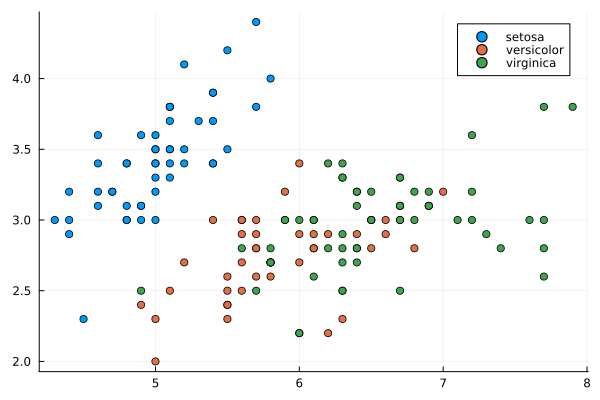

In [109]:
using Plots, StatsPlots

@df iris scatter(
        :SepalLength,
        :SepalWidth,
        group = :Species
)

It should be fairly easy to classify the setosa species, but the other species may be quite challenging.

Now we split the data into training and testing sets.

In [110]:
using MLJ # using the MLJ framework

y, X = unpack(iris, ==(:Species), !=(:Species))
train, test = partition(eachindex(y), 0.9, shuffle = true, rng = 123);

We now can fit the tree with the training data. We will start with a tree that overfits the data (has a large number of partitions/regions)

In [111]:
using MLJModels # loads the modesl MLJ can use e.g. linear regression, decision tree
tree_model = (@load DecisionTreeClassifier pkg=DecisionTree verbosity=0)()
tree_machine = machine(tree_model, X[train, :], y[train])
fit!(tree_machine);

[ Info: Training machine(DecisionTreeClassifier(max_depth = -1, …), …).


We can take a look at how our model classifies data by printing it.

In [112]:
fitted_params(tree_machine)[1]

PetalWidth < 0.8
├─ setosa (45/45)
└─ PetalWidth < 1.75
   ├─ PetalLength < 4.95
   │  ├─ PetalWidth < 1.65
   │  │  ├─ versicolor (45/45)
   │  │  └─ virginica (1/1)
   │  └─ PetalWidth < 1.55
   │     ├─ virginica (3/3)
   │     └─ PetalLength < 5.45
   │        ├─ versicolor (2/2)
   │        └─ virginica (1/1)
   └─ PetalLength < 4.85
      ├─ SepalLength < 6.05
      │  ├─ versicolor (1/1)
      │  └─ virginica (1/1)
      └─ virginica (36/36)


We compute the accuracy of the model

In [113]:
predictions = predict_mode(tree_machine, X[test, :])
mean(predictions .== y[test])

0.9333333333333333

This is actually quite a large out-of-sample accuracy. Although we have quite a large tree, it does not seem to overfit the data.

Regardless, we will now prune the tree through the purity threshold merging. We will use this procedure because the `MLJ` package does not provide a decision tree algorithm that uses cost-complexity pruning. This procedure goes backwards up the tree and decides whether to merge regions defined by a node if the purity (lack of diversity) of the resulting region as above a certain threshold. For the `DecisionTreeClassifier` class from the `DecisionTree` package, we can specify the purity threshold with the `merge_purity_threshold` option when constructing an instance of the class.

In [114]:
DecisionTreeClassifier = (@load DecisionTreeClassifier pkg=DecisionTree verbosity=0)
tree_model_prune = DecisionTreeClassifier(post_prune = true, merge_purity_threshold = 0.6)
tree_machine_prune = machine(tree_model_prune, X[train, :], y[train])
fit!(tree_machine_prune);

[ Info: Training machine(DecisionTreeClassifier(max_depth = -1, …), …).


This value for $\alpha$ gives us a significantly smaller tree

In [115]:
fitted_params(tree_machine_prune)[1]

PetalWidth < 0.8
├─ setosa (45/45)
└─ PetalWidth < 1.75
   ├─ versicolor (47/52)
   └─ PetalLength < 4.85
      ├─ SepalWidth < 3.0
      │  ├─ virginica (1/1)
      │  └─ versicolor (1/1)
      └─ virginica (36/36)


We can also see that it has a similar out-of-sample accuracy to the original model, so we are not losing performance from regularization

In [116]:
pruned_predictions = predict_mode(tree_machine_prune, X[test, :])
mean(pruned_predictions .== y[test])

0.9333333333333333

However, we have arbitrarily chosen the value for $\alpha$. We can also choose this value through cross-validation. `MLJ`'s's `evaluate!` function gives us a very useful abstraction for cross-validation.

In [117]:
thresholds = exp.(collect(-10:0.01:0))
innaccuracies = []

for threshold in thresholds
        tree_model_prune.merge_purity_threshold = threshold
        evaluation = evaluate!(
                tree_machine_prune,
                resampling = CV(nfolds = 3, shuffle = true, rng = 123),
                measure = Accuracy()
        )
        innaccuracies = [innaccuracies; 1 .- evaluation.measurement]
end

Let's plot the cross-validation error for each alpha

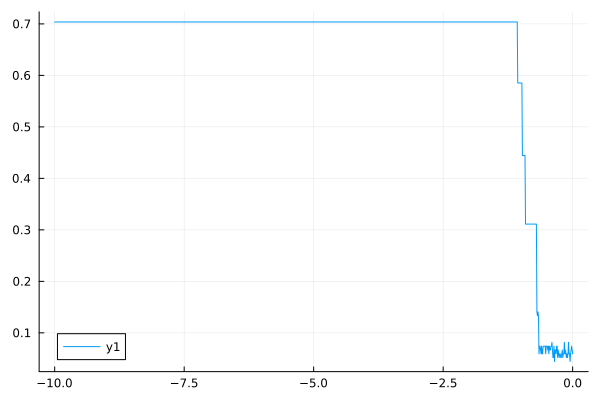

In [118]:
plot(log.(thresholds), innaccuracies)

We must take into account that the $K$-folds procedure gives us an *estimate* of the expected testing error; that is, the error when predicting with never-before-seen data. This estimate will depend on the size of our available sample and how it is split. With a relatively small sample like the one we are working with right now, this estimation may be noisy.

In this case, we will choose the optimal $\alpha$ as the one that minimizes the classification error (conversely, the one that maximizes the accuracy)

In [119]:
thresholds[argmin(innaccuracies)]

0.7046880897187134

Now we can take a look at the performance of this model when we use this value for $\alpha$

In [120]:
tree = DecisionTreeClassifier(post_prune = true, merge_purity_threshold = thresholds[argmin(innaccuracies)])
tree_machine_prune = machine(tree, X[train, :], y[train])
fit!(tree_machine_prune);

[ Info: Training machine(DecisionTreeClassifier(max_depth = -1, …), …).


In [121]:
pruned_predictions = predict_mode(tree_machine_prune, X[test, :])
mean(pruned_predictions .== y[test])

0.9333333333333333

In [122]:
fitted_params(tree_machine_prune)[1]

PetalLength < 2.45
├─ setosa (45/45)
└─ PetalWidth < 1.75
   ├─ PetalLength < 4.95
   │  ├─ versicolor (45/46)
   │  └─ PetalWidth < 1.55
   │     ├─ virginica (3/3)
   │     └─ SepalLength < 6.95
   │        ├─ versicolor (2/2)
   │        └─ virginica (1/1)
   └─ PetalLength < 4.85
      ├─ SepalWidth < 3.0
      │  ├─ virginica (1/1)
      │  └─ versicolor (1/1)
      └─ virginica (36/36)


## Regression

Now we will see an example more similar to what we have seen in class, because we will be using regression. We will be using the `Hitters` dataset provided by the `RDatasets` package through the `datasets` function.

### Baseball Data

Major League Baseball Data from the 1986 and 1987 seasons.

- `AtBat`: Number of times at bat in 1986

- `Hits`: Number of hits in 1986

- `HmRun`: Number of home runs in 1986

- `Runs`: Number of runs in 1986

- `RBI`: Number of runs batted in in 1986

- `Walks`: Number of walks in 1986

- `Years`: Number of years in the major leagues

- `CAtBat`: Number of times at bat during his career

- `CHits`: Number of hits during his career

- `CHmRun`: Number of home runs during his career

- `CRuns`: Number of runs during his career

- `CRBI`: Number of runs batted in during his career

- `CWalks`: Number of walks during his career

- `League`: A factor with levels A and N indicating player’s league at the end of 1986

- `Division`: A factor with levels E and W indicating player’s division at the end of 1986

- `PutOuts`: Number of put outs in 1986

- `Assists`: Number of assists in 1986

- `Errors`: Number of errors in 1986

- `Salary`: 1987 annual salary on opening day in thousands of dollars

- `NewLeague`: A factor with levels A and N indicating player’s league at the beginning of 1987

#### Notes

This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University. This is part of the data that was used in the 1988 ASA Graphics Section Poster Session. The salary data were originally from Sports Illustrated, April 20, 1987. The 1986 and career statistics were obtained from The 1987 Baseball Encyclopedia Update published by Collier Books, Macmillan Publishing Company, New York.

In [123]:
hitters = dataset("ISLR", "Hitters")
hitters[1:5, :]

Row,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
,Int32,Int32,Int32,Int32,Int32,Int32,Int32,Int32,Int32,Int32,Int32,Int32,Int32,Cat…,Cat…,Int32,Int32,Int32,Float64?,Cat…
1,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,missing,A
2,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
3,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
4,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
5,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


The data has some missing values, specifically in the `Salary` column. In this instance, we will just drop the missing data, but are several other ways to process missing values.

In [124]:
describe(hitters, :nmissing)

Row,variable,nmissing
,Symbol,Int64
1,AtBat,0
2,Hits,0
3,HmRun,0
4,Runs,0
5,RBI,0
6,Walks,0
7,Years,0
8,CAtBat,0
9,CHits,0


In [125]:
hitters = dropmissing(hitters, :Salary);

We will use the `unpack` function from the `MLJ` package to acquire our target vector and our feature matrix.

In [126]:
y, X = unpack(hitters, ==(:Salary), !=(:Salary));


To use a model in the `MLJ` package, the underlying `scitypes` of the variables must be compatible with the model. The `DecisionTreeRegressor` model type from the `DecisionTree` package is compatible with `Continuous` and `Multiclass` scitypes. However, because our data contains variables of type `Int32` these are interpreted as being of the scitype `Count`.

In [127]:
schema(X)

┌───────────┬───────────────┬─────────────────────────────────┐
│ names     │ scitypes      │ types                           │
├───────────┼───────────────┼─────────────────────────────────┤
│ AtBat     │ Count         │ Int32                           │
│ Hits      │ Count         │ Int32                           │
│ HmRun     │ Count         │ Int32                           │
│ Runs      │ Count         │ Int32                           │
│ RBI       │ Count         │ Int32                           │
│ Walks     │ Count         │ Int32                           │
│ Years     │ Count         │ Int32                           │
│ CAtBat    │ Count         │ Int32                           │
│ CHits     │ Count         │ Int32                           │
│ CHmRun    │ Count         │ Int32                           │
│ CRuns     │ Count         │ Int32                           │
│ CRBI      │ Count         │ Int32                           │
│ CWalks    │ Count         │ Int32     

 To make our model compatible with the data, first we perform a one-hot-encoding through the `OneHotEncoder` model of the `MLJModels` package

In [128]:
onehotencoder = @load OneHotEncoder pkg=MLJModels verbosity=0

ohe = onehotencoder(features = [:League, :Division, :NewLeague])
ohe_machine = machine(ohe, X)
fit!(ohe_machine);
X = MLJ.transform(ohe_machine, X);

[ Info: Training machine(OneHotEncoder(features = [:League, :Division, :NewLeague], …), …).
[ Info: Spawning 2 sub-features to one-hot encode feature :League.
[ Info: Spawning 2 sub-features to one-hot encode feature :Division.
[ Info: Spawning 2 sub-features to one-hot encode feature :NewLeague.


We check our data and see that the multiclass features are now considered continuous.

In [129]:
schema(X)

┌──────────────┬────────────┬─────────┐
│ names        │ scitypes   │ types   │
├──────────────┼────────────┼─────────┤
│ AtBat        │ Count      │ Int32   │
│ Hits         │ Count      │ Int32   │
│ HmRun        │ Count      │ Int32   │
│ Runs         │ Count      │ Int32   │
│ RBI          │ Count      │ Int32   │
│ Walks        │ Count      │ Int32   │
│ Years        │ Count      │ Int32   │
│ CAtBat       │ Count      │ Int32   │
│ CHits        │ Count      │ Int32   │
│ CHmRun       │ Count      │ Int32   │
│ CRuns        │ Count      │ Int32   │
│ CRBI         │ Count      │ Int32   │
│ CWalks       │ Count      │ Int32   │
│ League__A    │ Continuous │ Float64 │
│ League__N    │ Continuous │ Float64 │
│ Division__E  │ Continuous │ Float64 │
│ Division__W  │ Continuous │ Float64 │
│ PutOuts      │ Count      │ Int32   │
│ Assists      │ Count      │ Int32   │
│ Errors       │ Count      │ Int32   │
│ NewLeague__A │ Continuous │ Float64 │
│ NewLeague__N │ Continuous │ Float64 │


However, we will have to convert the `Count` features int `Continuous` features. We can do his with the `coerce!` function of the `MLJ` package, which does it inplace

In [130]:
coerce!(X, Count => Continuous);

Now we can partition our data with the `partition` function of the `MLJ` package

In [131]:
train, test = partition(eachindex(y), 0.9, rng = 1);

And train a tree without limiting parameters, such that we may overfit the training data

In [ ]:
DecisionTreeRegressor = (@load DecisionTreeRegressor pkg=DecisionTree verbosity=0)
tree_model = DecisionTreeRegressor()
tree_machine = machine(tree_model, X[train, :], y[train])
fit!(tree_machine);

[ Info: Training machine(DecisionTreeRegressor(max_depth = -1, …), …).


Now let's print this tree

In [133]:
fitted_params(tree_machine)[1]

CHits < 450.0
├─ AtBat < 147.0
│  ├─ 709.4666 (0/5)
│  └─ CRBI < 114.5
│     ├─ CRuns < 81.0
│     │  ├─ CRuns < 64.0
│     │  │  ├─ Hits < 69.5
│     │  │  │  ⋮
│     │  │  │  
│     │  │  └─ Runs < 45.0
│     │  │     ⋮
│     │  │     
│     │  └─ CAtBat < 842.5
│     │     ├─ CRuns < 100.5
│     │     │  ⋮
│     │     │  
│     │     └─ PutOuts < 151.5
│     │        ⋮
│     │        
│     └─ CWalks < 120.0
│        ├─ Walks < 29.5
│        │  ├─ 318.9375 (0/8)
│        │  └─ 215.0 (2/7)
│        └─ Walks < 45.0
│           ├─ 338.5 (0/5)
│           └─ 447.22222222222223 (0/9)
└─ Walks < 61.0
   ├─ AtBat < 365.0
   │  ├─ NewLeague__N < 0.5
   │  │  ├─ Hits < 76.5
   │  │  │  ├─ Errors < 5.5
   │  │  │  │  ⋮
   │  │  │  │  
   │  │  │  └─ 500.4166666666667 (0/6)
   │  │  └─ Years < 12.5
   │  │     ├─ CWalks < 264.5
   │  │     │  ⋮
   │  │     │  
   │  │     └─ PutOuts < 118.0
   │  │        ⋮
   │  │        
   │  └─ PutOuts < 771.0
   │     ├─ CRBI < 279.0
   │     │  ├─ CWalks

This tree is quite large and has a very large, meaning that it defines a large amount of regions/partitions. We can calculate the Root Mean Square Error of this tree in order to later compare it to a more conservative training procedure.

In [134]:
predictions = predict(tree_machine, X[test, :])
sqrt(mean((predictions - y[test]) .^ 2))

212.79287325701367

Like before, we can specify the `merge_purity_threshold` merge_purity_threshold `DecisionTreeRegressor` struct

In [135]:
tree_model_prune = DecisionTreeRegressor(post_prune = true, merge_purity_threshold = 0.09)
tree_machine_prune = machine(tree_model_prune, X[train, :], y[train])
fit!(tree_machine_prune);

[ Info: Training machine(DecisionTreeRegressor(max_depth = -1, …), …).


Now we can get a much smaller tree

In [136]:
fitted_params(tree_machine_prune)[1]

CHits < 450.0
├─ AtBat < 147.0
│  ├─ 709.4666 (0/5)
│  └─ CRBI < 114.5
│     ├─ CRuns < 81.0
│     │  ├─ 75.0 (5/40)
│     │  └─ CAtBat < 842.5
│     │     ├─ 155.0 (2/14)
│     │     └─ 250.0 (2/15)
│     └─ 350.0 (3/29)
└─ Walks < 61.0
   ├─ AtBat < 365.0
   │  ├─ 450.0 (4/39)
   │  └─ PutOuts < 771.0
   │     ├─ CRBI < 279.0
   │     │  ├─ 630.0 (1/11)
   │     │  └─ 850.0 (4/38)
   │     └─ 1156.6666666666665 (0/6)
   └─ RBI < 73.5
      ├─ 875.0 (2/21)
      └─ Years < 13.5
         ├─ CWalks < 457.5
         │  ├─ 1118.5714285714287 (0/7)
         │  └─ 2028.0118333333332 (0/6)
         └─ 992.4654999999999 (0/6)


Does it have better performance?

In [137]:
predictions_prune = predict(tree_machine_prune, X[test, :])
sqrt(mean((predictions_prune - y[test]) .^ 2))

189.97871696786015

It does perform better out of sample, meaning that we likely had a problem with overfittin the training data. Now we will follow the same procedure for $K$-folds cross-validation as before. The only difference is that we will use the Root Mean Square Error as our metric.

In [138]:
thresholds = exp.(collect(-10:0.01:0))
rmses = []

for threshold in thresholds
        tree_model_prune.merge_purity_threshold = threshold
        evaluation = evaluate!(
                tree_machine_prune,
                resampling = CV(nfolds = 3, shuffle = true, rng = 123),
                measure = rmse
        )
        rmses = [rmses; evaluation.measurement]
end

We plot the cross-validation errors against our grid of purity thresholds's

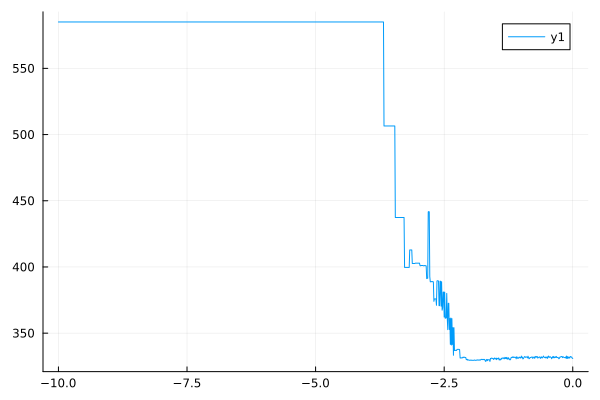

In [139]:
plot(log.(thresholds), rmses)

What is the optimal threshold in this scenario?

In [140]:
thresholds[argmin(rmses)]

0.18451952399298926

Let's now see if it gives us better performance than before. The same caveats for cross-validation as before apply here

In [141]:
tree_model_prune = DecisionTreeRegressor(post_prune = true, merge_purity_threshold = thresholds[argmin(rmses)])
tree_machine_prune = machine(tree_model_prune, X[train, :], y[train])
fit!(tree_machine_prune);
predictions_prune = predict(tree_machine_prune, X[test, :])
sqrt(mean((predictions_prune - y[test]) .^ 2))

[ Info: Training machine(DecisionTreeRegressor(max_depth = -1, …), …).


214.8897188951691

In [142]:
fitted_params(tree_machine_prune)[1]

CHits < 450.0
├─ AtBat < 147.0
│  ├─ 709.4666 (0/5)
│  └─ CRBI < 114.5
│     ├─ CRuns < 81.0
│     │  ├─ CRuns < 64.0
│     │  │  ├─ Hits < 69.5
│     │  │  │  ⋮
│     │  │  │  
│     │  │  └─ Runs < 45.0
│     │  │     ⋮
│     │  │     
│     │  └─ CAtBat < 842.5
│     │     ├─ CRuns < 100.5
│     │     │  ⋮
│     │     │  
│     │     └─ PutOuts < 151.5
│     │        ⋮
│     │        
│     └─ CWalks < 120.0
│        ├─ Walks < 29.5
│        │  ├─ 318.9375 (0/8)
│        │  └─ 215.0 (2/7)
│        └─ PutOuts < 154.5
│           ├─ 338.5 (0/5)
│           └─ 447.22222222222223 (0/9)
└─ Walks < 61.0
   ├─ AtBat < 365.0
   │  ├─ NewLeague__A < 0.5
   │  │  ├─ Years < 12.5
   │  │  │  ├─ CRuns < 414.0
   │  │  │  │  ⋮
   │  │  │  │  
   │  │  │  └─ 450.0 (2/10)
   │  │  └─ Hits < 76.5
   │  │     ├─ Errors < 5.5
   │  │     │  ⋮
   │  │     │  
   │  │     └─ 500.4166666666667 (0/6)
   │  └─ PutOuts < 771.0
   │     ├─ CRBI < 279.0
   │     │  ├─ CWalks < 177.0
   │     │  │  ⋮
   │    